### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

In [1]:
!pip3 install -q tensorflow_gpu #>=2.0

ERROR: tensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-serving-api 1.15.0 has requirement tensorflow~=1.15.0, but you'll have tensorflow 2.1.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
tf.test.is_gpu_available()


We then need to install *ktrain* library using pip.

In [3]:
!pip3 install -q ktrain

ERROR: tensorflow-serving-api 1.15.0 has requirement tensorflow~=1.15.0, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow-gpu 1.15.2 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.10.1 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement requests<3,>=2.21.0, but you'll have requests 2.20.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Load a Dataset Into Arrays

In [4]:
categories = ['med-question', 'no-question']

#### Get data from S3
_Option1_

```
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='my-bucket'
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

pd.read_csv(data_location)
```


_Option2_ (no boto3)

```
import pandas as pd

bucket='my-bucket'
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

pd.read_csv(data_location)
```


### Get from local file

In [150]:
import pandas as pd
df = pd.read_csv('qnoq-classifier/data/augmented_data_clean.csv')

In [151]:
df.head()

,text,target
0,england,0
1,hello i have a question,0
2,okay no thank you very much good night,0
3,how long will i be waiting to speak with a docter,0
4,merci,0


In [8]:
categories = ['no-question', 'med-question']

from sklearn.model_selection import train_test_split
trX, valX, trY, valY = train_test_split(df.text, df.target, test_size=0.15, random_state=42)


In [9]:
valX.values

array(['do you mean reductionism ?',
       'i can not do it in the morning greeting',
       'do you have any sibliings?', ...,
       'can i take an otc cystex with an antibiotic cephalexin for a uti?',
       'im an accountant and a stunt double as my second job',
       'and tell me about u'], dtype=object)

In [10]:
print('size of training set: %s' % (len(trX.values)))
print('size of validation set: %s' % (len(valX.values)))
print('classes: %s' % (set(trY.values)))

x_train = trX.values.tolist()
y_train = trY.values
x_test = valX.values.tolist()
y_test = valY.values

size of training set: 30694
size of validation set: 5417
classes: {0, 1}


## STEP 1:  Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [11]:
import ktrain ## it does work only with TF 2.1.0   (failing for TF 2.2.0-rc3)

In [12]:
#create model
from ktrain import text

MODEL_NAME = 'distilbert-base-uncased'

t = text.Transformer(MODEL_NAME, maxlen=500, class_names=categories)


In [13]:
#data preprocessing
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 8
	95percentile : 19
	99percentile : 29


preprocessing test...
language: en
test sequence lengths:
	mean : 8
	95percentile : 20
	99percentile : 29


In [14]:
#model training
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

## STEP 2:  Train the Model

**[Optional]**: Estimate a Good Learning Rate
Learning rates between 2e-5 and 5e-5 tend to work well with transformer models based on papers from Google. 

However, we can run our learning-rate-finder for two epochs to estimate the LR on this particular dataset.

```
learner.lr_find(show_plot=True, max_epochs=2)
```




For now, train using a [1cycle learning rate schedule](https://arxiv.org/pdf/1803.09820.pdf) with default settings.


In [16]:
learner.fit_onecycle(5e-5, 1)




begin training using onecycle policy with max lr of 5e-05...
Train for 5116 steps, validate for 170 steps
5116/5116 [==============================] - 3644s 712ms/step - loss: 0.0861 - accuracy: 0.9728 - val_loss: 0.0524 - val_accuracy: 0.9825


## STEP 3: Evaluate and Inspect the Model

In [17]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

 no-question       0.98      0.99      0.99      3251
med-question       0.98      0.98      0.98      2166

    accuracy                           0.98      5417
   macro avg       0.98      0.98      0.98      5417
weighted avg       0.98      0.98      0.98      5417



array([[3207,   44],
       [  51, 2115]])

Let's examine the validation example about which we were the most wrong.

In [18]:
learner.view_top_losses(n=5, preproc=t)

----------
id:2454 | loss:7.86 | true:med-question | pred:no-question)

----------
id:1787 | loss:7.72 | true:med-question | pred:no-question)

----------
id:936 | loss:7.23 | true:med-question | pred:no-question)

----------
id:5351 | loss:6.98 | true:no-question | pred:med-question)

----------
id:1682 | loss:6.62 | true:med-question | pred:no-question)



In [19]:
#wrong true label
print(x_test[2454])

hello sor how are you?


In [20]:
#confused by hospitalization
print(x_test[3970])

how true hospitalization b1? how true hospitalization b1?


In [24]:
#wrong true label
print(x_test[936])

ami never delayed me sk


In [21]:
#wrong true label ?
print(x_test[3623])

how long does a spermatozoon to arrive at the egg?


In [22]:
#wrong true label
print(x_test[1787])

keep saying this


In [25]:
#wrong true label
print(x_test[5351])

hbsag qualitative testresult negative unitdescriptive ref intervalnegative cut off value of 026 u  ml do i find my antigen testing?


In [23]:
#wrong true label
print(x_test[1682])

hi, im student in medicine , ! nice to meet you!?


#### Saving the model
We can save and reload our predictor for later deployment.

```python
predictor.save('/gdrive/My Drive/data/cases/my_distilbert_predictor')
```

#### Re-Loading the model

```python
import ktrain
reloaded_predictor = ktrain.load_predictor('/gdrive/My Drive/data/cases/my_distilbert_predictor')
```

## STEP 4: Making Predictions on New Data in Deployment

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [27]:
test_sentence = 'does weed take out or lower your serotonin levels in your brain?'

In [28]:
predictor.predict(test_sentence)

'med-question'

In [29]:
# predicted probability scores for each category
predictor.predict_proba(test_sentence)

array([5.6663557e-04, 9.9943334e-01], dtype=float32)

In [30]:
predictor.get_classes()

['no-question', 'med-question']

As expected, `med-question` is assigned the highest probability.

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [31]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
predictor.explain(test_sentence)

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.


### FURTHER TESTING PREDICTIONS

In [44]:
test_sentence = 'does weed take out or lower your serotonin levels in your brain?'

In [34]:
predictor.predict(test_sentence)

'med-question'

In [35]:
predictor.predict_proba(test_sentence)

array([5.6663557e-04, 9.9943334e-01], dtype=float32)

In [5]:
# Explain prediction
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [45]:
predictor.explain(test_sentence)

In [10]:
test_sentence = 'Hello how are you?'
reloaded_predictor.predict_proba(test_sentence)

array([9.9946254e-01, 5.3747103e-04], dtype=float32)

In [11]:
test_sentence = 'Hello how are you serotonin?'
reloaded_predictor.predict_proba(test_sentence)

array([0.8088109 , 0.19118915], dtype=float32)

In [22]:
test_sentence = 'Hello how are you'
print('test_sentence : ' , reloaded_predictor.predict_proba(test_sentence))

test_sentence :  [9.995433e-01 4.566679e-04]


In [38]:
def pred_length_test(sentence):
  tokens = sentence.split()
  messages = [' '.join(tokens[:z+1]) for z in range(len(tokens))]
  for msg in messages:
    print(msg, ' : ', predictor.predict_proba(msg))

In [39]:
#med_question test
pos_sentence = 'does weed take out or lower your serotonin levels in your brain ?'
pred_length_test(pos_sentence)

does  :  [9.9956065e-01 4.3930279e-04]


does weed  :  [9.9937254e-01 6.2750163e-04]


does weed take  :  [0.9630516  0.03694837]


does weed take out  :  [0.7163961  0.28360388]


does weed take out or  :  [0.55446714 0.44553286]


does weed take out or lower  :  [0.49648952 0.5035105 ]


does weed take out or lower your  :  [0.5274841  0.47251588]


does weed take out or lower your serotonin  :  [0.19440126 0.80559874]


does weed take out or lower your serotonin levels  :  [0.01611285 0.98388714]


does weed take out or lower your serotonin levels in  :  [0.00513185 0.99486816]


does weed take out or lower your serotonin levels in your  :  [0.02167702 0.978323  ]


does weed take out or lower your serotonin levels in your brain  :  [0.00872176 0.99127823]


does weed take out or lower your serotonin levels in your brain ?  :  [5.6663557e-04 9.9943334e-01]


In [40]:
#med_question test (no ?)
pos_sentence = 'does weed take out or lower your serotonin levels in your brain'
pred_length_test(pos_sentence)

does  :  [9.9956065e-01 4.3930279e-04]


does weed  :  [9.9937254e-01 6.2750163e-04]


does weed take  :  [0.9630516  0.03694837]


does weed take out  :  [0.7163961  0.28360388]


does weed take out or  :  [0.55446714 0.44553286]


does weed take out or lower  :  [0.49648952 0.5035105 ]


does weed take out or lower your  :  [0.5274841  0.47251588]


does weed take out or lower your serotonin  :  [0.19440126 0.80559874]


does weed take out or lower your serotonin levels  :  [0.01611285 0.98388714]


does weed take out or lower your serotonin levels in  :  [0.00513185 0.99486816]


does weed take out or lower your serotonin levels in your  :  [0.02167702 0.978323  ]


does weed take out or lower your serotonin levels in your brain  :  [0.00872176 0.99127823]


In [84]:
#med_question test
neg_sentence = 'is it going to rain tomorrow in Barcelona please tell me?'
pred_length_test(neg_sentence)

is  :  [9.9938488e-01 6.1512965e-04]


is it  :  [9.9922574e-01 7.7430706e-04]


is it going  :  [9.992324e-01 7.676080e-04]


is it going to  :  [9.9952626e-01 4.7373347e-04]


is it going to rain  :  [9.9956912e-01 4.3083646e-04]


is it going to rain tomorrow  :  [9.992416e-01 7.584221e-04]


is it going to rain tomorrow in  :  [0.9847643  0.01523575]


is it going to rain tomorrow in Barcelona  :  [0.9721726  0.02782736]


is it going to rain tomorrow in Barcelona please  :  [0.77594817 0.22405186]


is it going to rain tomorrow in Barcelona please tell  :  [0.7337253 0.2662747]


is it going to rain tomorrow in Barcelona please tell me?  :  [0.512008   0.48799202]


In [85]:
predictor.explain(neg_sentence)

In [42]:
#med_question test
neg_sentence = 'blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah'
pred_length_test(neg_sentence)

blah  :  [9.9958438e-01 4.1566373e-04]


blah blah  :  [9.9955541e-01 4.4453834e-04]


blah blah blah  :  [9.9952483e-01 4.7523942e-04]


blah blah blah blah  :  [9.9944216e-01 5.5782584e-04]


blah blah blah blah blah  :  [9.992798e-01 7.202138e-04]


blah blah blah blah blah blah  :  [9.9908018e-01 9.1980386e-04]


blah blah blah blah blah blah blah  :  [0.99862707 0.00137293]


blah blah blah blah blah blah blah blah  :  [0.99797076 0.00202924]


blah blah blah blah blah blah blah blah blah  :  [0.99677986 0.00322017]


blah blah blah blah blah blah blah blah blah blah  :  [0.9947299 0.0052701]


blah blah blah blah blah blah blah blah blah blah blah  :  [0.9930415  0.00695845]


blah blah blah blah blah blah blah blah blah blah blah blah  :  [0.9909237  0.00907631]


blah blah blah blah blah blah blah blah blah blah blah blah blah  :  [0.9882514  0.01174857]


blah blah blah blah blah blah blah blah blah blah blah blah blah blah  :  [0.9857525  0.01424751]


blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah  :  [0.9839897  0.01601028]


In [79]:
import random
def pred_shuffle_test(sentence):
  tokens = sentence.split()
  messages = [sentence]
  messages.extend([' '.join(random.sample(tokens, len(tokens))) for i in range(len(tokens))])
  for msg in messages:
    print(msg, ' : ', predictor.predict_proba(msg))

In [83]:
pos_sentence = 'does weed take out or lower your serotonin levels in your brain ?'
pred_shuffle_test(pos_sentence)

does weed take out or lower your serotonin levels in your brain ?  :  [5.6663557e-04 9.9943334e-01]


levels take out or in brain your weed serotonin does your ? lower  :  [0.00188543 0.9981146 ]


serotonin ? your levels your brain in weed take lower out does or  :  [0.00312106 0.996879  ]


? brain does your lower serotonin out your in or weed levels take  :  [0.00465414 0.9953459 ]


serotonin out in take weed or levels brain your does ? your lower  :  [0.00150339 0.99849665]


your or weed take serotonin out does levels lower ? your in brain  :  [0.00708427 0.99291575]


in or brain out your levels ? your does serotonin take weed lower  :  [0.00533259 0.9946674 ]


take does your in serotonin brain ? levels lower out weed or your  :  [0.00348663 0.9965134 ]


serotonin your lower ? your weed brain out in or does levels take  :  [0.00421232 0.9957877 ]


weed levels brain in your your out lower serotonin or take ? does  :  [7.020456e-04 9.992980e-01]


does serotonin levels out brain lower in your ? weed your take or  :  [0.00109447 0.99890554]


? out take your weed or your brain lower serotonin in does levels  :  [0.00741442 0.9925856 ]


your levels in serotonin lower brain ? does take or weed your out  :  [0.00685354 0.9931465 ]


your levels out or lower your brain serotonin take does ? in weed  :  [7.122800e-04 9.992878e-01]


In [82]:
neg_sentence = 'is it going to rain tomorrow in Barcelona please tell me?'
pred_shuffle_test(neg_sentence)

is it going to rain tomorrow in Barcelona please tell me?  :  [0.512008   0.48799202]


tell me? Barcelona going tomorrow in rain it to please is  :  [0.9201615  0.07983848]


rain me? please going to in tomorrow tell Barcelona is it  :  [0.9755182 0.0244818]


please Barcelona me? going rain tomorrow it is tell in to  :  [0.843094   0.15690602]


is Barcelona going me? tell in rain it tomorrow please to  :  [0.80030817 0.19969179]


to me? it tell in please tomorrow rain Barcelona going is  :  [0.57595176 0.4240483 ]


rain tomorrow is it going tell Barcelona me? please in to  :  [0.8597283  0.14027165]


rain Barcelona please me? going it tell tomorrow to in is  :  [0.9142664 0.0857336]


tomorrow it Barcelona me? to in tell going please is rain  :  [0.8709876  0.12901242]


me? to it please is rain Barcelona in going tell tomorrow  :  [0.6591127  0.34088734]


is please in going tomorrow me? Barcelona it to rain tell  :  [0.87381834 0.12618166]


tell Barcelona me? in please rain going tomorrow is to it  :  [0.84060776 0.15939228]


In [91]:
dummy_sentence = 'does weed take out or lower your cat levels in your mouse ?'
pred_shuffle_test(dummy_sentence)

 weed take out or lower your cat levels in your mouse ?  :  [0.01108927 0.9889107 ]


cat take levels lower in your your mouse out or weed ?  :  [0.01065729 0.9893427 ]


lower ? your out mouse take cat your or in levels weed  :  [0.36385486 0.6361451 ]


? take your lower your cat weed or in mouse out levels  :  [0.24561357 0.7543864 ]


or take in lower mouse cat your out ? weed your levels  :  [0.3276616 0.6723384]


levels lower cat ? weed or take out mouse your your in  :  [0.4376185 0.5623815]


lower your weed ? levels or out take your cat in mouse  :  [0.5677997  0.43220034]


out or ? weed take cat your in your levels lower mouse  :  [0.32614657 0.67385346]


your out mouse your levels in weed ? take lower cat or  :  [0.2633609  0.73663914]


out or cat ? lower levels your in weed your mouse take  :  [0.4106577  0.58934224]


cat or your ? levels weed out lower in your take mouse  :  [0.3497258  0.65027416]


levels lower ? your weed take cat out or in mouse your  :  [0.36150655 0.6384934 ]


or ? cat weed lower take out your your mouse in levels  :  [0.19041654 0.8095835 ]


In [90]:
dummy2_sentence = 'chat dogs take out or lower your cat kilos in your mouse ?'
pred_shuffle_test(dummy2_sentence)

chat dogs take out or lower your cat kilos in your mouse ?  :  [0.86597776 0.1340222 ]


in dogs chat your your mouse or cat lower ? kilos take out  :  [0.86529934 0.13470072]


or take out ? chat in mouse dogs lower kilos cat your your  :  [0.95935774 0.04064226]


chat your out kilos in lower ? or cat your mouse dogs take  :  [0.9105316  0.08946843]


or out chat cat your kilos your dogs in lower take ? mouse  :  [0.8433072  0.15669273]


? chat or kilos your lower take in mouse out cat dogs your  :  [0.842816   0.15718406]


cat your dogs in take lower chat your mouse kilos out ? or  :  [0.696358   0.30364195]


cat your kilos take dogs lower in your mouse ? or out chat  :  [0.8164396  0.18356036]


lower dogs out or your your chat kilos mouse cat in take ?  :  [0.96702    0.03298005]


? in cat kilos your mouse out or lower your dogs chat take  :  [0.9294475  0.07055259]


lower or cat kilos chat take mouse ? dogs your your out in  :  [0.97648424 0.02351573]


? lower take or dogs out your mouse cat chat kilos in your  :  [0.9249318 0.0750682]


or take kilos your dogs lower in your out cat mouse chat ?  :  [0.81598413 0.18401591]


take dogs mouse kilos or your out chat ? in cat lower your  :  [0.9632865  0.03671345]


In [88]:
predictor.explain(dummy2_sentence)

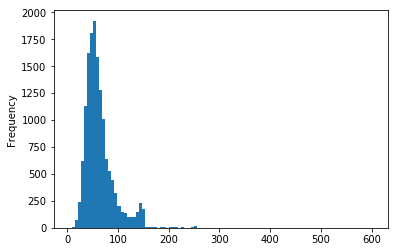

In [97]:
df[df.target==1].text.str.len().plot.hist(bins=100)

In [107]:
np.sum(df[df.target==0].text.str.len() > 20) 

12542

In [105]:
np.sum(df[df.target==1].text.str.len() > 30)

13994

### TEST ON INTERNAL MED QUESTIONS

In [109]:
!ls

lost+found  qnoq-classifier


In [112]:
dfmed = pd.read_csv('qnoq-classifier/data/abi_questions_nondup.csv')

In [113]:
dfmed.head()

,text,target
0,the question i have to 9 years the latter year...,1
1,hello my question is that i operated 3 times ...,1
2,pain can prevail above the navel and come on f...,1
3,i have tested positive on the 27th after havin...,1
4,i have type 1 diabetes and pcos and prolactino...,1


In [115]:
dfmed['pred'] = dfmed.text.apply(lambda x : predictor.predict_proba(x))

In [119]:
dfmed.columns = ['text', 'target', 'probas']
dfmed.head()

,text,target,probas
0,the question i have to 9 years the latter year...,1,"[0.9799154, 0.020084577]"
1,hello my question is that i operated 3 times ...,1,"[0.005857231, 0.99414283]"
2,pain can prevail above the navel and come on f...,1,"[0.00383623, 0.9961637]"
3,i have tested positive on the 27th after havin...,1,"[0.023165394, 0.9768346]"
4,i have type 1 diabetes and pcos and prolactino...,1,"[0.0007821092, 0.99921787]"


In [121]:
dfmed['pred'] = dfmed.probas.apply(lambda x : x[1]>0.5)

In [122]:
dfmed.head()

,text,target,probas,pred
0,the question i have to 9 years the latter year...,1,"[0.9799154, 0.020084577]",0.020085
1,hello my question is that i operated 3 times ...,1,"[0.005857231, 0.99414283]",0.994143
2,pain can prevail above the navel and come on f...,1,"[0.00383623, 0.9961637]",0.996164
3,i have tested positive on the 27th after havin...,1,"[0.023165394, 0.9768346]",0.976835
4,i have type 1 diabetes and pcos and prolactino...,1,"[0.0007821092, 0.99921787]",0.999218


In [123]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dfmed.target, (dfmed.pred > 0.5))


array([[   0,    0],
       [ 208, 2405]])

In [131]:
#display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [136]:
dfmed[dfmed.pred < 0.5][['text','pred']].style.set_properties(subset=['text'], **{'width': '600px'})

,text,pred
0,the question i have to 9 years the latter years met a girl he traveled with her to bed with her ive known now he works for the said q n has nothing works only q q is good worker but it hurts me a lot thism sad very sad q do not im depressed,0.020085
7,ive rang my gp just waiting for him to contact me thanks not sure yet what the outcome will b???? not sure? ill wait to here from my gp thanks x ?? the answer from your doctors was to contact my gp so i have but still waiting?,0.240815
9,good day i worked pap smears she that the tribe cekat misec half days now im interested if it is not something good for how much roughly call immediately or yesterday has been done pap smears hvala,0.457415
10,thank you sorry to waste your time but i did get checked out and was clear but was taking itraconazola at the time and thought it cleared it up and i thought i might have given it to partner basically just getting bad anxiety at the time but you cleared it up with the first question sorry to waste your time,0.270016
16,yesterday arranging valancil chair on a table ma fell on the nose today i bothers the area you i think that may be relevant,0.407223
36,i will explain the situation when my sisters have problems when you couple others live it as our own and we are wrong and do not go out but now im the one who has problems because the father of my partner is sick do not see the same reactions thats being selfish or bad sisters?,0.326118
38,the baby has an older sister by two years which it constantly touching but i fear that is not of its rukica can it be? thank you baby behaves normally i do not think it bothers him,0.485406
39,dr arthur katona he thought original parity would appear it hasnt so far,0.282824
40,oh you did not understand me did i get the wrong expressed first i asked for a child to ask for a blood draw and this now i ask for myself it has nothing to do with the child a child you very much for your reply i did not know how to exploit the babies blood because we have not went,0.337285
46,but sometimes if you have not done nap and also costs then he goes very tired during the day and the fact that when this me ask your father?,0.284975


In [141]:
dfmed['len'] = dfmed.text.str.len()

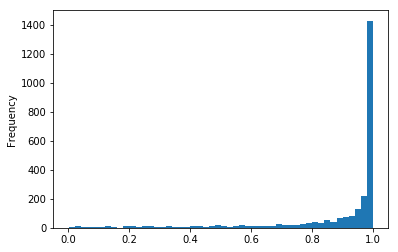

In [142]:
dfmed.pred.plot.hist(bins=50)

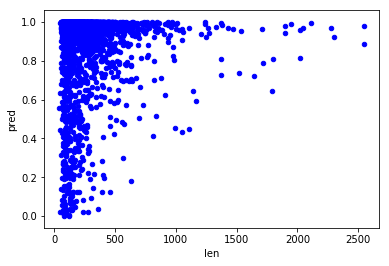

In [148]:
dfmed.plot.scatter(x='len',y='pred',c='blue')

In [139]:
dfmed[dfmed.pred > 0.9][['text','pred']].style.set_properties(subset=['text'], **{'width': '600px'})

,text,pred
1,hello my question is that i operated 3 times a trenchant abdominal hernia now two and half months ago and i have pain many days ago and i noticed the lump again in the same place to make matters worse very weak and i have detected the bacteria coli,0.994143
2,pain can prevail above the navel and come on for 15 seconds and then stops menstruation i finished 194 and was normal nausea came suddenly and now takes more than 18 hours yesterday,0.996164
3,i have tested positive on the 27th after having sex with one possible father is it possible to test so early and be positive,0.976835
4,i have type 1 diabetes and pcos and prolactinoma tumour in pituitary gland secreting excess prolactin i am on medication for all of these things but recently i have been gaining a lot of weight around my stomach my skin all over my body is really bad doesnt repair itself and leaves me scarred and bruised and my hair keeps falling out not to mention the fatigue and depression i have been really stressed and i am suspecting i might have cushings syndrome maybe the disease because i already have an adenoma in the pituitary am i right in my self diagnosis?,0.999218
5,i have classic cold symptoms like a runny nose a productive cough and dull headache however i also feel faint cold to my bones no matter how many layers i put on and i have muscle pain all over my body,0.998570
6,i am celiac diagnosed a week agothe gluten has been removed and since i have removed it i am worse plus gas and soft decision once a day tb i am lactose intolerant and i have irritable bowel,0.998234
11,i have pain in one eye on it is a diopter in the red i think 175 while the other eye in the green painful around for years feel like more and if you take a closer look shows that the swollen area around the eye the pupil is wider and very sensitive to cold especially wind and knows narrowed days if me a little flushed with wind or air while i sleep to be about half open and sometimes narrow and while i sleep it constantly feel a dull ache like id been hit all regular time to do the eye test were normal can you recommend some additional time or point me what to do this has been going on for years and does not improve it thank you,0.975665
12,the odds are high or low? and you can do if you no longer served the morning after pill?,0.984445
13,is it possible to catch the gastrointestinal if it has already had in november?,0.998816
15,hi i was eating some pringles about five minutes later my lips went very swollen,0.959054
